If you've written a layer or model definition you're happy with, you can use Thinc's function registry to register it and assign it a string name. Your function can take any arguments that can later be defined in the config. Adding **type hints** ensures that config settings will be **parsed and validated** before they're passed into the function, so you don't end up with incompatible settings and confusing failures later on. Here's the MNIST model, defined as a custom layer:

# Prepare the environment

Install the dependencies and import the necessary packages.

> GraphViz must be installed in your system in order to visualize the model

In [1]:
!pip install "thinc>=8.0.0a0" ml_datasets "tqdm>=4.41" pydot graphviz svgwrite

In [2]:
import matplotlib.pyplot as plt
from typing import Union, Iterable
from tqdm.notebook import tqdm
import itertools
import pydot
from IPython.display import SVG, display

import thinc
from thinc.api import chain, Relu, Softmax, Config, registry
from thinc.types import FloatsXd

import ml_datasets


# Utility functions

In [3]:

def train_model(data, model, optimizer, n_iter, batch_size):
    (train_X, train_Y), (test_X, test_Y) = data
    for i in range(n_iter):
        batches = model.ops.multibatch(batch_size, train_X, train_Y, shuffle=True)
        for X, Y in tqdm(batches, leave=False):
            Yh, backprop = model.begin_update(X)
            backprop(Yh - Y)
            model.finish_update(optimizer)
        # Evaluate and print progress
        correct = 0
        total = 0
        for X, Y in model.ops.multibatch(batch_size, test_X, test_Y):
            Yh = model.predict(X)
            correct += (Yh.argmax(axis=1) == Y.argmax(axis=1)).sum()
            total += Yh.shape[0]
        score = correct / total
        print(f" {i} {float(score):.3f}")


In [4]:

def get_label(layer):
    layer_name = layer.name
    nO = layer.get_dim("nO") if layer.has_dim("nO") else "?"
    nI = layer.get_dim("nI") if layer.has_dim("nI") else "?"
    return f"{layer.name}|({nI}, {nO})".replace(">", "&gt;")

def visualize_model(model):
    dot = pydot.Dot()
    dot.set("rankdir", "LR")
    dot.set_node_defaults(shape="record", fontname="arial", fontsize="10")
    dot.set_edge_defaults(arrowsize="0.7")
    nodes = {}
    for i, layer in enumerate(model.layers):
        label = get_label(layer)
        node = pydot.Node(layer.id, label=label)
        dot.add_node(node)
        nodes[layer.id] = node
        if i == 0:
            continue
        from_node = nodes[model.layers[i - 1].id]
        to_node = nodes[layer.id]
        if not dot.get_edge(from_node, to_node):
            dot.add_edge(pydot.Edge(from_node, to_node))
    display(SVG(dot.create_svg()))

# Create and register a custom optmizer

In [5]:
class MyCoolOptimizer():
    def __init__(self, learn_rate: float, gamma: Iterable[float]):
        self.eta = learn_rate
        self.gamma = gamma
    
    def __repr__(self):
        return f"MyCoolOptimizer(eta={self.eta}, gamma={self.gamma})"

    def __call__(self, weights: FloatsXd, gradient: FloatsXd):
        """Call the optimizer with weights and a gradient. The key is the
        identifier for the parameter, usually the node ID and parameter name.
        """
        # the optimization logic goes here :)
        param, grad =  self._my_cool_logic(weights, gradient)
        return param, grad

    def _my_cool_logic(self, weights, gradient):
        #dummy placeholder
        pass


op = MyCoolOptimizer(2.0, 3.0)
print(op)

MyCoolOptimizer(eta=2.0, gamma=3.0)


In [6]:
@thinc.registry.optimizers.register("my_cool_optimizer.v1")
def make_my_optimizer(learn_rate: Union[float, Iterable[float]], gamma: float):
    return MyCoolOptimizer(learn_rate, gamma)

# Later you can retrieve your function by name:
create_optimizer = thinc.registry.optimizers.get("my_cool_optimizer.v1")
create_optimizer

<function __main__.make_my_optimizer(learn_rate: Union[float, Iterable[float]], gamma: float)>

In [7]:
@thinc.registry.schedules("my_cool_decaying_schedule.v1")
def decaying(base_rate: float, decay: float, *, t: int = 0) -> Iterable[float]:
    while True:
        yield base_rate * (1.0 / (1.0 + decay * t))
        t += 1

In [8]:
CONFIG = """[optimizer]
@optimizers = "my_cool_optimizer.v1"
gamma = 1e-8

[optimizer.learn_rate]
@schedules = "my_cool_decaying_schedule.v1"
base_rate = 0.001
decay = 1e-4
"""

config = Config().from_str(CONFIG)
C = registry.make_from_config(config)
C['optimizer']

MyCoolOptimizer(eta=<generator object decaying at 0x7f7fc0a4f9d0>, gamma=1e-08)

## Variable positional arguments example

In some cases your registered function may accept variable positional arguments. In your config, you can then use `*` to define a list of values:

```yaml
[schedule]
@schedules = "my_cool_schedule.v1"
* = [0.05, 0.1, 0.25, 0.75, 0.9]
final = 1.0
```


> Type hints for variable arguments should always describe the type of the individual arguments.



In [9]:
@thinc.registry.schedules("my_cool_schedule.v1")
def schedule(*steps: float, final: float = 1.0) -> Iterable[float]:
    yield from steps
    while True:
        yield final

In [10]:
CONFIG= """[optimizer]
@optimizers = "my_cool_optimizer.v1"
gamma = 1e-8

[optimizer.learn_rate]
@schedules = "my_cool_decaying_schedule.v1"
base_rate = 0.001
decay = 1e-4

[schedule]
@schedules = "my_cool_schedule.v1"
* = [0.05, 0.1, 0.25, 0.75, 0.9]
final = 1.0
"""
config = Config().from_str(CONFIG)
C = registry.make_from_config(config)
my_schedule = C['schedule']
my_schedule

<generator object schedule at 0x7f7fc0a4fc50>

In [11]:
# print the first 10 elements of the `schedule` object
list(itertools.islice(my_schedule, 10))

[0.05, 0.1, 0.25, 0.75, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0]

# Register a model

In [12]:
@thinc.registry.layers("MNIST.v1")
def create_mnist(nO: int, dropout: float):
    return chain(
        Relu(nO, dropout=dropout), 
        Relu(nO, dropout=dropout), 
        Softmax()
    )

In the config, we can now refer to it by name and set its arguments. This makes the config maintainable and compact, while still allowing you to change and record the hyperparameters.

In [13]:
CONFIG = """
[model]
@layers = "MNIST.v1"
nO = 32
dropout = 0.2

[optimizer]
@optimizers = "Adam.v1"
learn_rate = 0.001

[training]
n_iter = 10
batch_size = 128
"""

config = Config().from_str(CONFIG)
config

{'model': {'@layers': 'MNIST.v1', 'nO': 32, 'dropout': 0.2},
 'optimizer': {'@optimizers': 'Adam.v1', 'learn_rate': 0.001},
 'training': {'n_iter': 10, 'batch_size': 128}}

You can also wrap the dataset in a registry function.
Before make sure you have all the dependencies settled. For this example, install the `ml_datasets` package and import all the objects used in the configuration.


In [14]:
@thinc.registry.datasets("mnist_data.v1")
def mnist():
    return ml_datasets.mnist()

In [15]:
CONFIG = """
[model]
@layers = "MNIST.v1"
nO = 32
dropout = 0.2

[optimizer]
@optimizers = "Adam.v1"
learn_rate = 0.001

[training]
n_iter = 10
batch_size = 128

[training.data]
@datasets = "mnist_data.v1"
"""

config = Config().from_str(CONFIG)
loaded_config = registry.make_from_config(config)
loaded_config

{'model': <thinc.model.Model at 0x7f7fc0a86950>,
 'optimizer': <thinc.optimizers.Optimizer at 0x7f7fc0a9e260>,
 'training': {'n_iter': 10,
  'batch_size': 128,
  'data': ((array([[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
    array([[0., 0., 0., ..., 1., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 1., 0., 0.],
           [1., 0., 0., ..., 0., 0., 0.],
           [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)),
   (array([[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0.

In [16]:
# Now you can use the objects in the registry:
model = loaded_config["model"]
optimizer = loaded_config["optimizer"]
n_iter = loaded_config["training"]["n_iter"]
batch_size = loaded_config["training"]["batch_size"]
data = (train_X, train_Y), (dev_X, dev_Y) = loaded_config["training"]["data"]

# After loading the data from config, they might still need to be moved to the right device
train_X = model.ops.asarray(train_X)
train_Y = model.ops.asarray(train_Y)
dev_X = model.ops.asarray(dev_X)
dev_Y = model.ops.asarray(dev_Y)

model.initialize(X=train_X[:5], Y=train_Y[:5])


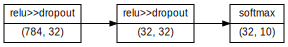

In [17]:
visualize_model(model)

In [18]:
train_model(data, model, optimizer, n_iter, batch_size)


0 0.840


1 0.879


2 0.893


3 0.904


4 0.912


5 0.919


6 0.920


7 0.920


8 0.926


9 0.927
